# Определение перспективного тарифа для телеком-компании

**Описание проекта**

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Тариф «Смарт»**
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); сообщение: 3 рубля; 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: минута разговора: 1 рубль; сообщение: 1 рубль; 1 Гб интернет-трафика: 150 рублей.

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">

   **Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.
    
</div>

##  Изучение данных из файла

Импортируем необходимые библиотеки и сохраним данные в переменных:

In [1]:
import pandas as pd # импорт библиотеки pandas 
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
import numpy as np # импорт библиотеки numpy
from scipy import stats as st # импорт библиотеки scipy
import math as m # импорт библиотеки math

In [2]:
calls = pd.read_csv('/datasets/calls.csv', sep=',')
internet = pd.read_csv('/datasets/internet.csv', sep=',', index_col=0) # убираем столбец Unnamed
messages = pd.read_csv('//datasets/messages.csv', sep=',')
tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')
users = pd.read_csv('/datasets/users.csv', sep=',')

pd.options.display.max_columns = None # полностью отображаем столбцы

Выведем общую информацию о данных:

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


**Таблица `calls` (информация о звонках):**
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">

   **Примечание:**

Звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.
    
</div>

In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [6]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


**Таблица `internet` (информация об интернет-сессиях):**
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [8]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


**Таблица `messages` (информация о сообщениях):**
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщени

In [9]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [10]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Таблица `tariffs` (информация о тарифах):**

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со * 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [12]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


**Таблица users (информация о пользователях):**

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана

### Вывод

Общий стиль названий таблиц выдержан.

Лишь в таблице `users` отсутсвуют значения в дате прекращения пользования тарифом потому, что тариф еще использовался абонентом.

В таблице `tariffs` содержится общая информация о тарифах.

Приступим к предобработке данных:

## Предобработка данных

Перед тем, как провести анализ данных, проведем предобработку:

* проверим дубликаты
* проверим возможные ошибки и исправим их
* объединим таблицы для анализа данных помесячно.


Проверим дубликаты в таблицах:

In [13]:
display(
    calls.duplicated().sum(),
    internet.duplicated().sum(),
    messages.duplicated().sum(),
    users.duplicated().sum(),
)

0

0

0

0

Дубликаты отсутствуют

Изменим формат времени и добавим в таблицы год и месяц, чтобы создать единый помесячный датасет:

In [14]:
# переводим в формат DateTime
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# добавляем столбец с годом / месяцем
calls['month'] = pd.DatetimeIndex(calls['call_date']).map(lambda x: x.strftime('%Y-%m'))

calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,2018-07
1,1000_1,2018-08-17,0.00,1000,2018-08
2,1000_2,2018-06-11,2.85,1000,2018-06
3,1000_3,2018-09-21,13.80,1000,2018-09
4,1000_4,2018-12-15,5.18,1000,2018-12


In [15]:
# переводим в формат DateTime
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%dT')

# добавляем столбец с годом / месяцем
internet['month'] = pd.DatetimeIndex(internet['session_date']).map(lambda x: x.strftime('%Y-%m'))

internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,2018-11
1,1000_1,1052.81,2018-09-07,1000,2018-09
2,1000_2,1197.26,2018-06-25,1000,2018-06
3,1000_3,550.27,2018-08-22,1000,2018-08
4,1000_4,302.56,2018-09-24,1000,2018-09


In [16]:
# переводим в формат DateTime
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%dT')

# добавляем столбец с годом / месяцем
messages['month'] = pd.DatetimeIndex(messages['message_date']).map(lambda x: x.strftime('%Y-%m'))

messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06
1,1000_1,2018-10-08,1000,2018-10
2,1000_2,2018-08-04,1000,2018-08
3,1000_3,2018-06-16,1000,2018-06
4,1000_4,2018-12-05,1000,2018-12


Добавим в таблицу calls общие минуты каждого звонка (звонки округляются до минут):

In [17]:
# округляем в большую сторону с помощью библиотеки math
calls['minutes'] = calls['duration'].apply(m.ceil)

calls.head()

,id,call_date,duration,user_id,month,minutes
0,1000_0,2018-07-25,0.00,1000,2018-07,0
1,1000_1,2018-08-17,0.00,1000,2018-08,0
2,1000_2,2018-06-11,2.85,1000,2018-06,3
3,1000_3,2018-09-21,13.80,1000,2018-09,14
4,1000_4,2018-12-15,5.18,1000,2018-12,6


### Проверка ошибок данных

Построим гистограммы по количественным данным в таблицах и проверим, есть ошибки в данных.

Text(0.5, 1.0, 'Продолжительность звонков')

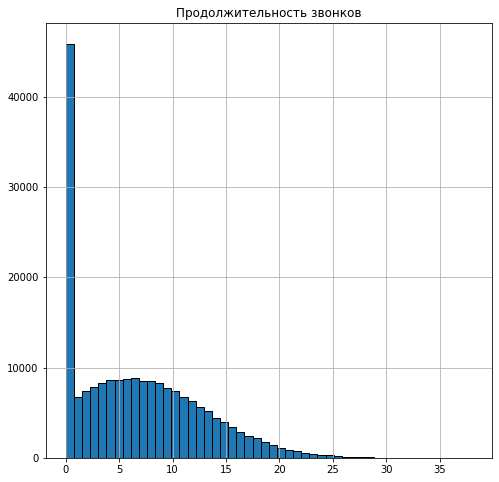

In [18]:
calls.hist('duration', bins=50, ec='black', figsize=(8,8))
plt.title('Продолжительность звонков')

Text(0.5, 1.0, 'Количество сообщений')

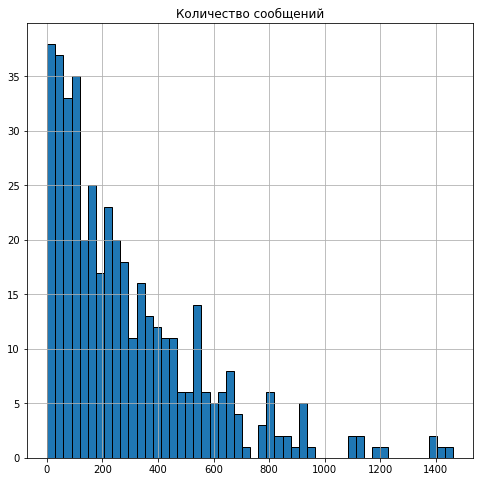

In [19]:
messages.pivot_table(index='user_id', values='id', aggfunc='count').hist(bins=50, ec='black', figsize=(8,8))
plt.title('Количество сообщений')

Text(0.5, 1.0, 'Количество использованных мегабайт')

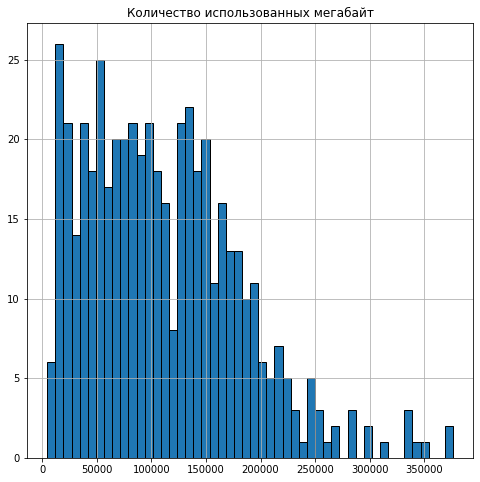

In [20]:
internet.pivot_table(index='user_id', values='mb_used', aggfunc='sum').hist(bins=50, ec='black', figsize=(8,8))
plt.title('Количество использованных мегабайт')

**Вывод:**

* В продолжительности звонков самые большие показатели в `0` потому, что есть большое количество "дозвонов". Выбросов и ошибок нет.
* В количестве сообщений тоже не имеется ошибок. Их много у `0` и максимум сообщений близкий к 1500. Цифры за месяц вполне реалистичные. 
* Использованный траффик - тоже близкое к реальности. Но людей, которые не используют интернет очень мало, по сравнению с другими таблицами.

В таблицах не замечено критических ошибок и замечаний, нет больших выбросов. Нет необходимости в корректировки ошибок.

### Объединение таблиц

Создаем сводные таблицы по месяцам для каждого абонента каждой таблицы:

In [21]:
# сводная таблица по звонкам в месяц. Создаём две таблицы с количеством звонков и временем звонка и объединяем

calls_month = calls.pivot_table(index=['user_id', 'month'], 
                                    values='minutes', 
                                    aggfunc=('sum', 'count'))
calls_month = calls_month.rename(columns={'sum':'calls_minutes', 'count':'calls_count'})

calls_month

calls_count  calls_minutes
user_id month                              
1000    2018-05           22            159
        2018-06           43            172
        2018-07           47            340
        2018-08           52            408
        2018-09           58            466
...                      ...            ...
1498    2018-10           41            247
1499    2018-09            9             70
        2018-10           68            449
        2018-11           74            612
        2018-12           69            492

[3174 rows x 2 columns]

In [22]:
# сводная таблица по траффику в месяц

internet_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')

# делим на 1024 для перевода в гб и округляем
internet_month['gb_used'] = (internet_month['mb_used'] / 1024).apply(m.ceil)

internet_month

mb_used  gb_used
user_id month                     
1000    2018-05   2253.49        3
        2018-06  23233.77       23
        2018-07  14003.64       14
        2018-08  14055.93       14
        2018-09  14568.91       15
...                   ...      ...
1498    2018-10  20579.36       21
1499    2018-09   1845.75        2
        2018-10  17788.51       18
        2018-11  17963.31       18
        2018-12  13055.58       13

[3203 rows x 2 columns]

In [23]:
# сводная таблица по сообщениям в месяц

messages_month = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_month = messages_month.rename(columns={'id':'messages'})

messages_month

messages
user_id month            
1000    2018-05        22
        2018-06        60
        2018-07        75
        2018-08        81
        2018-09        57
...                   ...
1498    2018-10        42
1499    2018-09        11
        2018-10        48
        2018-11        59
        2018-12        66

[2717 rows x 1 columns]

In [24]:
# общая сводная таблица

main_pivot = calls_month.merge(internet_month, on=['user_id','month'], how='outer')
main_pivot = main_pivot.merge(messages_month, on=['user_id','month'], how='outer')
main_pivot = main_pivot.reset_index(level = 'month')

main_pivot

,month,calls_count,calls_minutes,mb_used,gb_used,messages
user_id,,,,,,
1000,2018-05,22.0,159.0,2253.49,3.0,22.0
1000,2018-06,43.0,172.0,23233.77,23.0,60.0
1000,2018-07,47.0,340.0,14003.64,14.0,75.0
1000,2018-08,52.0,408.0,14055.93,14.0,81.0
1000,2018-09,58.0,466.0,14568.91,15.0,57.0
...,...,...,...,...,...,...
1489,2018-08,NaN,NaN,11050.56,11.0,17.0
1489,2018-09,NaN,NaN,17206.30,17.0,32.0
1489,2018-10,NaN,NaN,19559.44,20.0,21.0


Проверим, есть ли пользователи, которые меняли тариф и стали с новым `id`:

In [25]:
users['full_name'] = users['first_name'] + ' ' + users['last_name']

users['full_name'].value_counts().unique()

array([1])

Пользователи не повторяются.

In [26]:
users['full_name'].duplicated().sum()

0

Добавим информацию в сводную таблицу о пользователе и тарифе:

In [27]:
main_pivot = main_pivot.merge(users[['user_id', 'tariff']], on='user_id')
main_pivot = main_pivot.merge(tariffs, left_on='tariff', right_on ='tariff_name')
main_pivot = main_pivot.drop('tariff_name', axis='columns')

main_pivot

,user_id,month,calls_count,calls_minutes,mb_used,gb_used,messages,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05,22.0,159.0,2253.49,3.0,22.0,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-06,43.0,172.0,23233.77,23.0,60.0,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-07,47.0,340.0,14003.64,14.0,75.0,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-08,52.0,408.0,14055.93,14.0,81.0,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-09,58.0,466.0,14568.91,15.0,57.0,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,2018-08,NaN,NaN,11050.56,11.0,17.0,smart,50,15360,500,550,200,3,3
3210,1489,2018-09,NaN,NaN,17206.30,17.0,32.0,smart,50,15360,500,550,200,3,3
3211,1489,2018-10,NaN,NaN,19559.44,20.0,21.0,smart,50,15360,500,550,200,3,3
3212,1489,2018-11,NaN,NaN,17491.56,18.0,20.0,smart,50,15360,500,550,200,3,3


Заполним пропуски в таблице и преобразуем значения в столбцах:

In [28]:
# заполняем пропущенные значения 0, так как абонент просто не пользовался услугой

main_pivot['calls_minutes'] = main_pivot['calls_minutes'].fillna(0).astype('int')
main_pivot['calls_count'] = main_pivot['calls_count'].fillna(0).astype('int')
main_pivot['gb_used'] = main_pivot['gb_used'].fillna(0).astype('int')
main_pivot['messages'] = main_pivot['messages'].fillna(0).astype('int')

# добавляем столбец с количеством гигабайт
main_pivot['gb_per_month_included'] = (main_pivot['mb_per_month_included'] / 1024).astype('int')

main_pivot

,user_id,month,calls_count,calls_minutes,mb_used,gb_used,messages,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,2018-05,22,159,2253.49,3,22,ultra,1000,30720,3000,1950,150,1,1,30
1,1000,2018-06,43,172,23233.77,23,60,ultra,1000,30720,3000,1950,150,1,1,30
2,1000,2018-07,47,340,14003.64,14,75,ultra,1000,30720,3000,1950,150,1,1,30
3,1000,2018-08,52,408,14055.93,14,81,ultra,1000,30720,3000,1950,150,1,1,30
4,1000,2018-09,58,466,14568.91,15,57,ultra,1000,30720,3000,1950,150,1,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,2018-08,0,0,11050.56,11,17,smart,50,15360,500,550,200,3,3,15
3210,1489,2018-09,0,0,17206.30,17,32,smart,50,15360,500,550,200,3,3,15
3211,1489,2018-10,0,0,19559.44,20,21,smart,50,15360,500,550,200,3,3,15
3212,1489,2018-11,0,0,17491.56,18,20,smart,50,15360,500,550,200,3,3,15


### Расчет необходимых значений

**Посчитаем для каждого пользователя:**

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Для каждого пользователя первые значения уже имеются их общих таблиц, соотвественно, рассчитаем помесячную выручку с каждого пользователя:

In [29]:
# составим функцию, которая посчитает итог для каждого тарифа. Находим превышения по лимитам
# и прибавляем к тарифной ставке

def count_fee(row):
    for_min = 0
    for_mes = 0
    for_gb = 0
    if row['calls_minutes'] > row['minutes_included']:
        for_min = (row['calls_minutes'] - row['minutes_included']) * row['rub_per_minute']
    if row['messages'] > row['messages_included']:
        for_mes = (row['messages'] - row['messages_included']) * row['rub_per_message']
    if row['gb_used'] > row['gb_per_month_included']:
        for_gb = (row['gb_used'] - row['gb_per_month_included']) * row['rub_per_gb']
    return row['rub_monthly_fee'] + for_min + for_mes + for_gb
    
main_pivot['fee_final'] = main_pivot.apply(count_fee, axis=1)

main_pivot

,user_id,month,calls_count,calls_minutes,mb_used,gb_used,messages,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,fee_final
0,1000,2018-05,22,159,2253.49,3,22,ultra,1000,30720,3000,1950,150,1,1,30,1950
1,1000,2018-06,43,172,23233.77,23,60,ultra,1000,30720,3000,1950,150,1,1,30,1950
2,1000,2018-07,47,340,14003.64,14,75,ultra,1000,30720,3000,1950,150,1,1,30,1950
3,1000,2018-08,52,408,14055.93,14,81,ultra,1000,30720,3000,1950,150,1,1,30,1950
4,1000,2018-09,58,466,14568.91,15,57,ultra,1000,30720,3000,1950,150,1,1,30,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,2018-08,0,0,11050.56,11,17,smart,50,15360,500,550,200,3,3,15,550
3210,1489,2018-09,0,0,17206.30,17,32,smart,50,15360,500,550,200,3,3,15,950
3211,1489,2018-10,0,0,19559.44,20,21,smart,50,15360,500,550,200,3,3,15,1550
3212,1489,2018-11,0,0,17491.56,18,20,smart,50,15360,500,550,200,3,3,15,1150


### Вывод

Выведен общий датасет с необходимыми столбцами для дальнейшего анализа данных.

Итого строк: `3214`

## Анализ полученных данных

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы и опишем распределения.

### Необходимый объём пользователя по месяцам

Рассмотрим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц:

Построим сводную таблицу средних значений по месяцам для каждого тарифа:

In [30]:
pd.options.display.float_format = '{:.2f}'.format
main_pivot_mean = main_pivot.pivot_table(index='month', 
                                         columns='tariff', 
                                         values=['calls_minutes', 'gb_used', 'messages', 'fee_final'], 
                                         aggfunc='mean')

main_pivot_mean

calls_minutes        fee_final         gb_used       messages      
tariff          smart  ultra     smart   ultra   smart ultra    smart ultra
month                                                                      
2018-01        203.85 428.11    721.32 1950.00    8.74 13.22    18.24 33.78
2018-02        298.69 297.12    827.60 1975.00   11.84 12.00    24.09 21.96
2018-03        390.05 489.65   1164.62 2014.86   15.23 17.65    31.86 32.30
2018-04        367.13 458.02    963.09 2001.82   13.62 16.96    30.74 31.56
2018-05        387.36 510.33   1197.51 2059.70   15.91 19.37    33.77 37.85
2018-06        395.64 479.70   1204.02 2039.29   15.95 18.94    33.40 41.73
2018-07        408.35 545.79   1223.95 2118.13   15.88 20.51    33.75 49.85
2018-08        421.47 510.78   1320.60 2083.18   16.74 19.60    33.64 48.44
2018-09        428.61 539.44   1249.95 2024.35   16.39 19.24    33.64 52.29
2018-10        426.14 558.08   1364.85 2065.85   16.88 20.07    33.77 58.43
2018-11        435.27 541.38   1343.05 2092.16   17.00 19.81    34.08 55.79
2018-12        478.56 592.81   1578.53 2138.85   18.20 21.74    35.99 60.61

Используя таблицу, построим столбчатые диаграммы по использованным объёмам и тарифам:

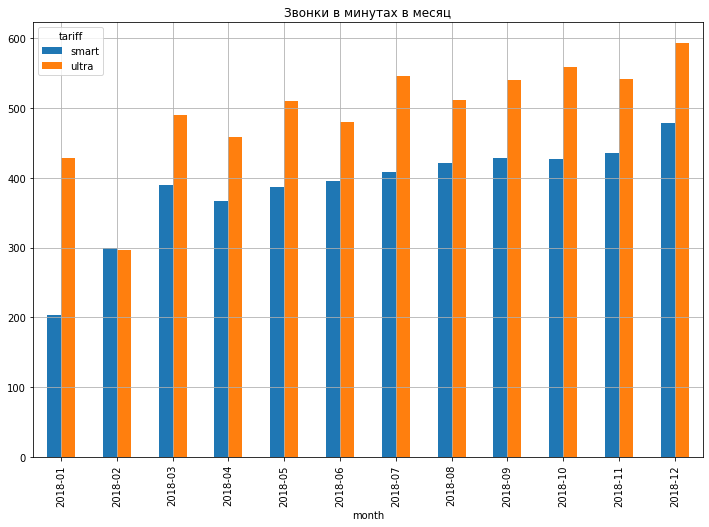

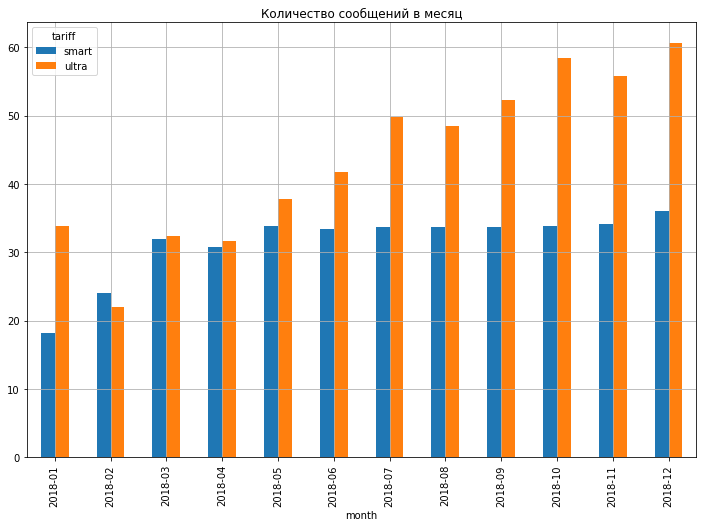

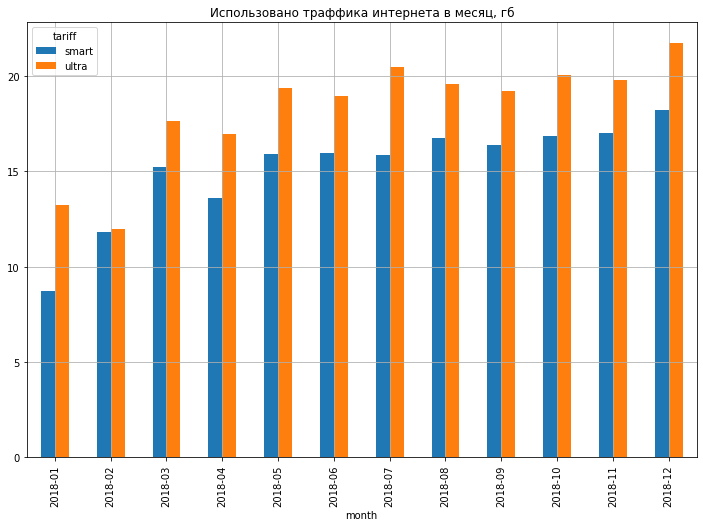

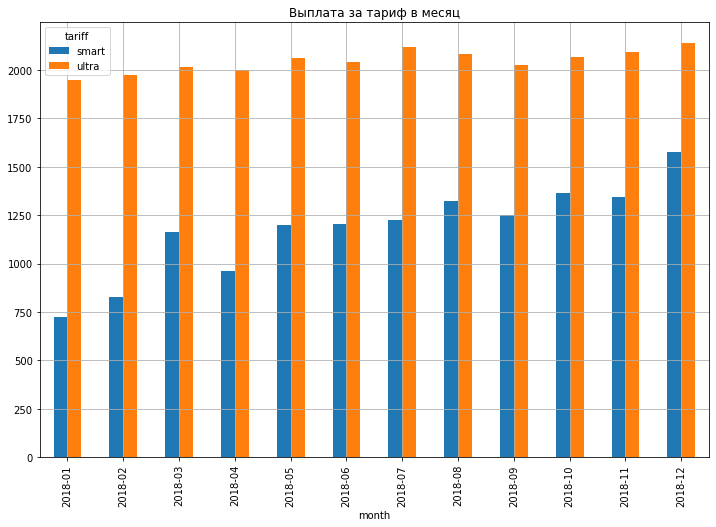

In [31]:
main_pivot_mean.plot(title='Звонки в минутах в месяц', 
                     y='calls_minutes', 
                     grid=True, figsize=(12, 8), kind='bar')

main_pivot_mean.plot(title='Количество сообщений в месяц', 
                     y='messages', 
                     grid=True, figsize=(12, 8), kind='bar')

main_pivot_mean.plot(title='Использовано траффика интернета в месяц, гб', 
                     y='gb_used', 
                     grid=True, figsize=(12, 8), kind='bar')

main_pivot_mean.plot(title='Выплата за тариф в месяц', 
                     y='fee_final', 
                     grid=True, figsize=(12, 8), kind='bar')

Исходя из полученных значений, можно сделать вывод:

* Пользователи тарифа `ultra` наиболее активные пользователи. Они пользуются услугами оператора больше, чем пользователи тарифа `smart`.
* Пользователи тарифа `smart` в среднем всегда платят выше тарифа, а пользователи иного тарифа почти всегда платят тарифную ставку.
* В тарифе `ultra` сообщений всегда использовано больше, кроме как в период с февраля по апрель.
* Тенденция в течении года по использованным объёмам идёт на повышение, потребности пользователей в течении года растут. В декабре больше всего абоненты используют тариф. 
* Пользователи тарифа `ultra` приносят компании *Мегалайн* больше прибыли, чем абоненты `smart`. Даже маленький лимит по выданным минутам/гигабайтам/сообщениям в тарифе `smart` помесячно в сумме не превышает `ultra`.
* Менее всего пользователи активны в феврале.

### Рассчёт среднего количество, дисперсии и стандартного отклонения.

**Рассчитаем среднее и стандартное отклонение:**

**Для тарифа `smart`:**

In [32]:
# сводная таблица по тарифу smart

main_pivot_smart = main_pivot.query('tariff == "smart"')[['calls_minutes', 'gb_used', 'messages', 'fee_final']]

main_pivot_smart.describe()

,calls_minutes,gb_used,messages,fee_final
count,2229.00,2229.00,2229.00,2229.00
mean,417.93,16.33,33.38,1289.97
std,190.31,5.75,28.23,818.40
min,0.00,0.00,0.00,550.00
25%,282.00,13.00,10.00,550.00
50%,422.00,17.00,28.00,1023.00
75%,545.00,20.00,51.00,1750.00
max,1435.00,38.00,143.00,6770.00


Построим ящики с усами для интерпретации результатов:

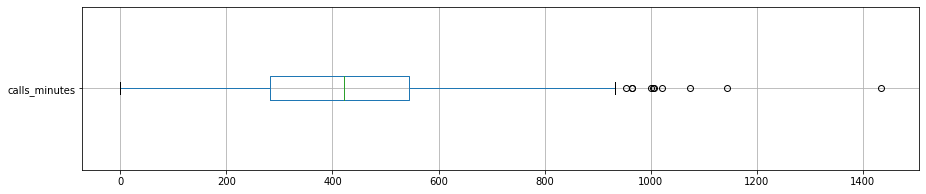

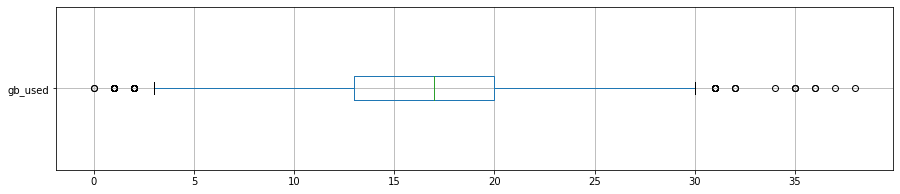

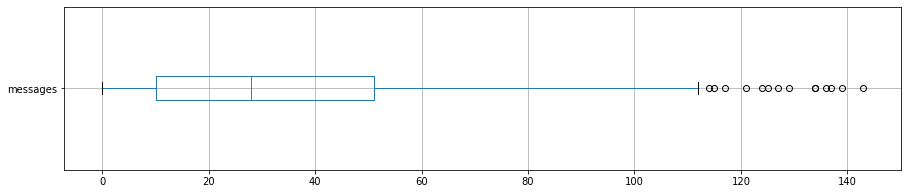

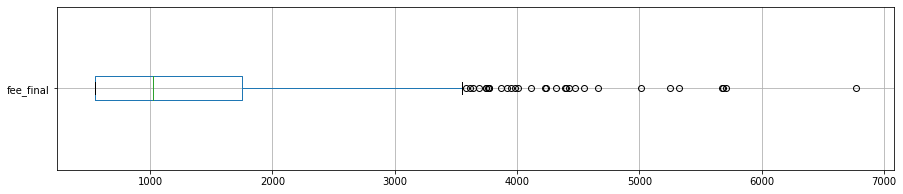

In [33]:
main_pivot_smart.boxplot('calls_minutes', vert=False, figsize=(15,3))
plt.show()

main_pivot_smart.boxplot('gb_used', vert=False, figsize=(15,3))
plt.show()

main_pivot_smart.boxplot('messages', vert=False, figsize=(15,3))
plt.show()

main_pivot_smart.boxplot('fee_final', vert=False, figsize=(15,3))
plt.show()

**Для тарифа `ultra`:**

In [34]:
# сводная таблица по тарифу ultra

main_pivot_ultra = main_pivot.query('tariff == "ultra"')[['calls_minutes', 'gb_used', 'messages', 'fee_final']]

main_pivot_ultra.describe()

,calls_minutes,gb_used,messages,fee_final
count,985.00,985.00,985.00,985.00
mean,526.62,19.49,49.36,2070.15
std,317.61,9.85,47.80,376.19
min,0.00,0.00,0.00,1950.00
25%,284.00,12.00,6.00,1950.00
50%,518.00,19.00,38.00,1950.00
75%,752.00,27.00,79.00,1950.00
max,1673.00,49.00,224.00,4800.00


Построим ящики с усами для интерпретации результатов:

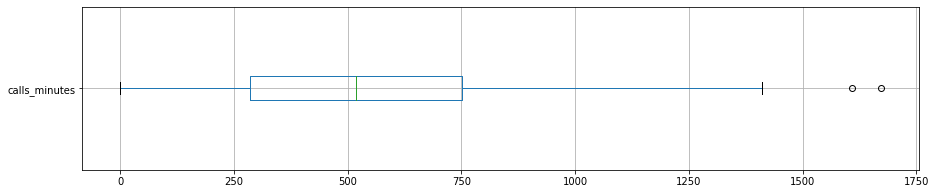

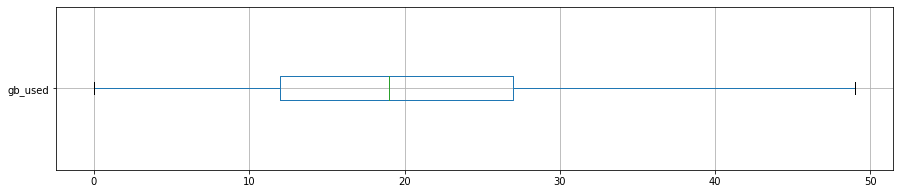

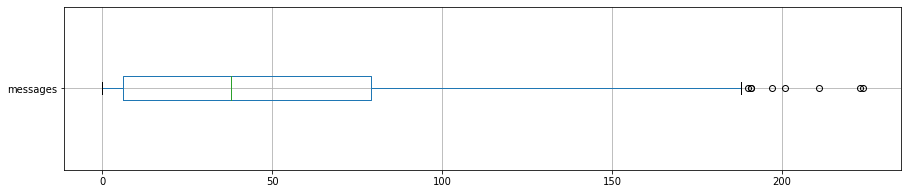

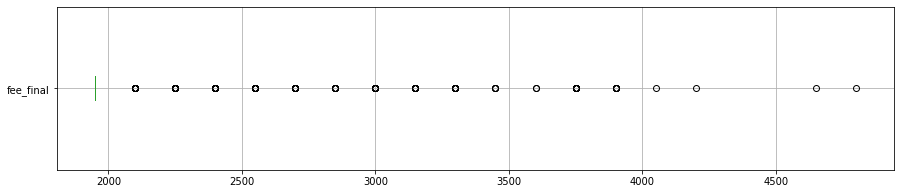

In [35]:
main_pivot_ultra.boxplot('calls_minutes', vert=False, figsize=(15,3))
plt.show()

main_pivot_ultra.boxplot('gb_used', vert=False, figsize=(15,3))
plt.show()

main_pivot_ultra.boxplot('messages', vert=False, figsize=(15,3))
plt.show()

main_pivot_ultra.boxplot('fee_final', vert=False, figsize=(15,3))
plt.show()

**Рассчитаем дисперсию**

In [36]:
# воспользуемся библиотекой numpy

var_smart = np.var(main_pivot_smart, ddof=1)
var_smart

calls_minutes    36219.32
gb_used             33.03
messages           796.81
fee_final       669785.71
dtype: float64

In [37]:
var_ultra = np.var(main_pivot_ultra, ddof=1)
var_ultra

calls_minutes   100873.63
gb_used             97.09
messages          2285.27
fee_final       141516.75
dtype: float64

Дисперсии по итоговой выплате сильно отличаются, стоит это учесть при проверке гипотез.

**Построем гистограммы**

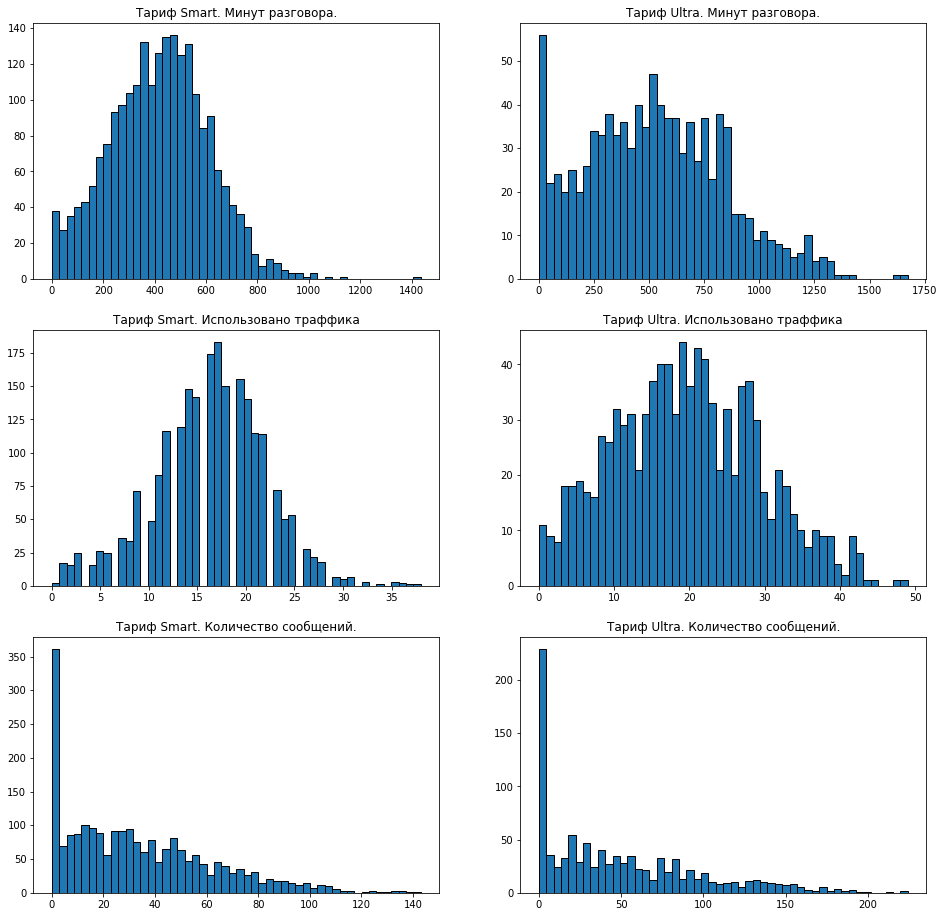

In [38]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,16))

axs[0,0].hist(data=main_pivot_smart, x='calls_minutes', bins=50, ec='black')
axs[0,1].hist(data=main_pivot_ultra, x='calls_minutes', bins=50, ec='black')
axs[1,0].hist(data=main_pivot_smart, x='gb_used', bins=50, ec='black')
axs[1,1].hist(data=main_pivot_ultra, x='gb_used', bins=50, ec='black')
axs[2,0].hist(data=main_pivot_smart, x='messages', bins=50, ec='black')
axs[2,1].hist(data=main_pivot_ultra, x='messages', bins=50, ec='black')

axs[0,0].set_title('Тариф Smart. Минут разговора.')
axs[0,1].set_title('Тариф Ultra. Минут разговора.')
axs[1,0].set_title('Тариф Smart. Использовано траффика')
axs[1,1].set_title('Тариф Ultra. Использовано траффика')
axs[2,0].set_title('Тариф Smart. Количество сообщений.')
axs[2,1].set_title('Тариф Ultra. Количество сообщений.')

plt.show()

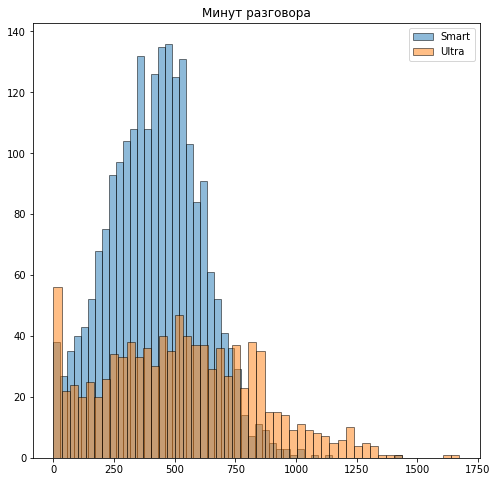

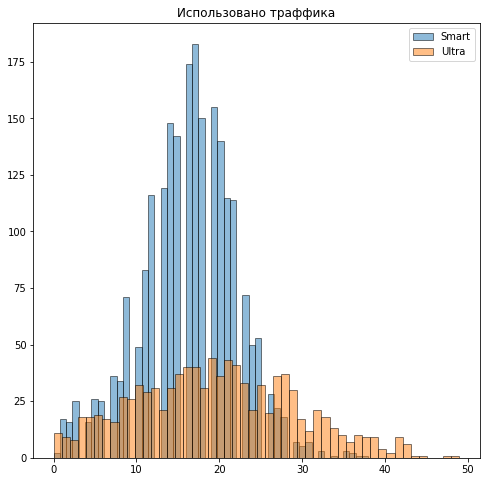

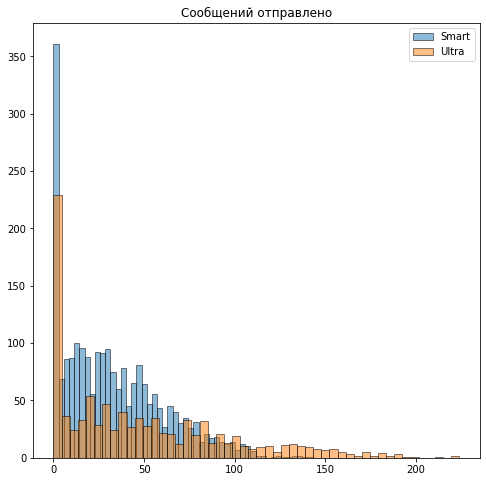

In [39]:
plt.figure(figsize=(8,8))
plt.hist(data=main_pivot_smart, x='calls_minutes', bins=50, ec='black', alpha=0.5, label='Smart')
plt.hist(data=main_pivot_ultra, x='calls_minutes', bins=50, ec='black', alpha=0.5, label='Ultra')
plt.legend(loc='upper right')
plt.title('Минут разговора')
plt.show()

plt.figure(figsize=(8,8))
plt.hist(data=main_pivot_smart, x='gb_used', bins=50, ec='black', alpha=0.5, label='Smart')
plt.hist(data=main_pivot_ultra, x='gb_used', bins=50, ec='black', alpha=0.5, label='Ultra')
plt.legend(loc='upper right')
plt.title('Использовано траффика')
plt.show()

plt.figure(figsize=(8,8))
plt.hist(data=main_pivot_smart, x='messages', bins=50, ec='black', alpha=0.5, label='Smart')
plt.hist(data=main_pivot_ultra, x='messages', bins=50, ec='black', alpha=0.5, label='Ultra')
plt.legend(loc='upper right')
plt.title('Сообщений отправлено')
plt.show()

### Вывод

Исходя из полученных данных из всех графиков и полученных данных сделаем выводы:

* Количество пользователей `smart` меньше, чем `ultra`
* В тарифе `ultra` больше всего абонентов, которые даже не пользуются звонками, либо просто делают "дозвон". И никто из пользователей не достиг лимита по звонкам.
* Исходя из стандартного отклонения, абоненты тарифа `smart` чаще превышают лимит по звонкам и переплачивают за время.
* Исходя из стандартного отклонения по итоговой выплате, абоненты тарифа `smart` в среднем переплачивают.
* Большинство абонентов тарифа `smart` превышают лимит по гигабайтам. В тарифе `ultra` таких пользователей меньше.
* Никто из пользователей обоих тарифов не достиг лимита по сообщениям.

## Проверка гипотез

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Составим нулевую гипотезу:
* средняя выручка пользователей тарифов Smart и Ultra не различается.

И альтернативная гипотеза будет:
* средняя выручка пользователей тарифов Smart и Ultra различается.

Гипотеза о равенстве средних двух генеральных совокупностей.
Применяем двусторонний критерий, так как разница в выручке по тарифу `smart` и `ultra` может быть как в положительную сторону, так и в отрицательную.

In [40]:
# совокупности по выплате по тарифам
smart_fee = main_pivot_smart['fee_final']
ultra_fee = main_pivot_ultra['fee_final']

alpha = .05

# дисперсии отличаются, значит задаем параметр equal_var=False
results = st.ttest_ind(
    smart_fee, 
    ultra_fee, 
    equal_var=False)
    
print('p-значение:', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Есть предположение, что гипотезу можно отвергнуть, значит, в среднем, вероятно, пользователи тарифа `ultra` платят больше.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Прежде, чем построить нулевую и альтернативную гипотезу, объединим таблицы:

In [41]:
main_pivot = main_pivot.merge(users, on='user_id')

In [42]:
main_pivot

,user_id,month,calls_count,calls_minutes,mb_used,gb_used,messages,tariff_x,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,fee_final,age,churn_date,city,first_name,last_name,reg_date,tariff_y,full_name
0,1000,2018-05,22,159,2253.49,3,22,ultra,1000,30720,3000,1950,150,1,1,30,1950,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Рафаил Верещагин
1,1000,2018-06,43,172,23233.77,23,60,ultra,1000,30720,3000,1950,150,1,1,30,1950,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Рафаил Верещагин
2,1000,2018-07,47,340,14003.64,14,75,ultra,1000,30720,3000,1950,150,1,1,30,1950,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Рафаил Верещагин
3,1000,2018-08,52,408,14055.93,14,81,ultra,1000,30720,3000,1950,150,1,1,30,1950,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Рафаил Верещагин
4,1000,2018-09,58,466,14568.91,15,57,ultra,1000,30720,3000,1950,150,1,1,30,1950,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,Рафаил Верещагин
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,2018-08,0,0,11050.56,11,17,smart,50,15360,500,550,200,3,3,15,550,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,Павел Гончаров
3210,1489,2018-09,0,0,17206.30,17,32,smart,50,15360,500,550,200,3,3,15,950,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,Павел Гончаров
3211,1489,2018-10,0,0,19559.44,20,21,smart,50,15360,500,550,200,3,3,15,1550,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,Павел Гончаров
3212,1489,2018-11,0,0,17491.56,18,20,smart,50,15360,500,550,200,3,3,15,1150,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,Павел Гончаров


Нулевая гипотеза:
* средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

Алтернативная гипотеза:
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Гипотеза о равенстве средних двух генеральных совокупностей.
Применяем двусторонний критерий, так как разница в выручке по Москве и другим городам может быть как в положительную сторону, так и в отрицательную.

In [43]:
# совокупности по выплате по городам
moscow_fee = main_pivot.query('city == "Москва"')['fee_final']
other_fee = main_pivot.query('city != "Москва"')['fee_final']

alpha = .05

# предположим, что совокупности отличаются, и дисперсия тоже
results = st.ttest_ind(
    moscow_fee, 
    other_fee, 
    equal_var=False)
    
print('p-значение:', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Гипотеза не отвергнута, а значит нет принципиальной разницы между выплатами по тарифу в Москве и других городах.

# Общий вывод

Общий вывод по всем полученным данным:
* Пользователи тарифа `ultra` наиболее активные пользователи. Они пользуются услугами оператора больше, чем пользователи тарифа `smart`.
* Пользователи тарифа `smart` в среднем всегда платят выше тарифа, а пользователи иного тарифа почти всегда платят тарифную ставку. Исходя из стандартного отклонения по итоговой выплате, абоненты тарифа `smart` в среднем переплачивают.
* Пользователи тарифа `ultra` приносят больше прибыли, чем абоненты `smart`. Даже маленький лимит по выданным минутам / гигабайтам / сообщениям в тарифе `smart` помесячно в сумме не превышает `ultra`.
* Большинство абонентов тарифа `smart` превышают лимит по гигабайтам траффика. В тарифе `ultra` таких пользователей меньше.
* Пользователи тарифа `ultra` платят больше, чем абоненты тарифа `smart`.
* Абоненты из Москвы не платят больше, чем жители других городов, значит нет принципиальной разницы по рекламировании в зависимости от города.

Исходя из изложенной задачи: *Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше*, делаем вывод:

Тариф `ultra` куда выгоднее в плане использования предоставленных лимитов. Абоненты данного тарифа редко выходят сверх данного лимита. Для компании выгоднее чаще рекламировать данный тариф, так как клиенты платят за него больше, по сравнению с клиентами тарифа `smart`. И активному пользователю сотовой сети, в тарифе `smart` вряд ли хватит выданных лимитов.